In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.append('../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175, Omega_b = 0.049, h = 0.6711, sigma8 = 0.834, n_s = 0.9649, 
                      matter_power_spectrum='linear')

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar = np.load('./default_config.npy', allow_pickle = True)[()]

#Just to make the variation in params more extreme
bpar['mu_beta'] = 1

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

## Download files

These are files from the [ULAGAM simulations](https://ulagam-simulations.readthedocs.io/) hosted on gdrive specifically for this example notebook

In [3]:
!rm shell.fits.fz halos.npy

!wget -O shell.fits.fz "https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6"
!wget -O halos.npy     "https://drive.google.com/uc?export=download&id=1JhtFwOzfHG5YWXUDYP1HFfAkq6v5YHKm"

--2024-10-21 10:23:46--  https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6
Resolving drive.google.com (drive.google.com)... 142.250.191.174, 2607:f8b0:4009:819::200e
Connecting to drive.google.com (drive.google.com)|142.250.191.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download [following]
--2024-10-21 10:23:46--  https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.191.161, 2607:f8b0:4009:819::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.191.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5705280 (5.4M) [application/octet-stream]
Saving to: ‘shell.fits.fz’

shell.fits.fz       100%[===================>]   5.44M  5.93MB/s    in

## Load shell and catalog

In [4]:
min_z = 0.2129219
max_z = 0.2395602

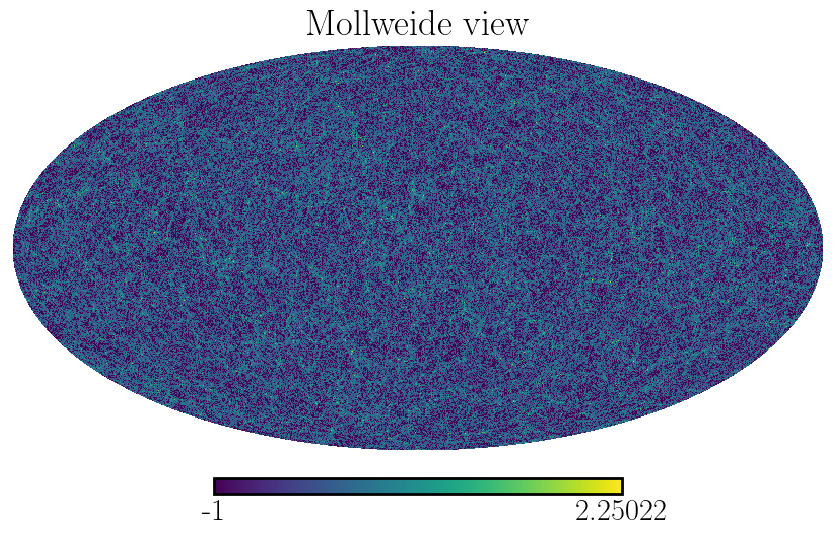

In [5]:
counts  = fits.open('shell.fits.fz')[1].data
density = counts/np.mean(counts) - 1

hp.mollview(np.log10(1.1 + density))

In [6]:
halos = np.load('halos.npy')

In [7]:
shell_thickness = ccl.comoving_radial_distance(cosmo, 1/(max_z + 1)) - ccl.comoving_radial_distance(cosmo, 1/(min_z + 1))
bpar['proj_cutoff'] = shell_thickness/2

print(f"SHELL IS {shell_thickness} MPC")

SHELL IS 103.99377965173323 MPC


In [8]:
#This is set in units of halo R200c radius.
#You want this to be larger than the radius where you displacement
#function asymptotes to 0
bpar['epsilon_max'] = 10

## Now setup the models

In [ ]:
#Generate a series of 5 models, varying a parameter (M_c)

M_c_vals = [1e12, 1e13, 1e14, 1e15, 1e16]
Model    = []
for M_c in M_c_vals:
    
    bpar['M_c'] = M_c
    
    #DMO and DMB models
    DMO = bfg.Profiles.DarkMatterOnly(**bpar)
    DMB = bfg.Profiles.DarkMatterBaryon(**bpar)
    
    PIX = bfg.HealPixel(1024)
    DMO = bfg.ConvolvedProfile(DMO, PIX)
    DMB = bfg.ConvolvedProfile(DMB, PIX)

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfg.Profiles.Baryonification2D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
    Displacement.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)
    
    Model.append(Displacement)

Building Table:   0%|                                                                             | 0/2 [00:00<?, ?it/s]/home/dhaya/miniconda3/envs/test_env/lib/python3.11/site-packages/Baryonification/Profiles/Schneider19.py:964: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (6.666666666666666e-10)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
Building Table: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


## Now setup the runners

In [ ]:
#Each model gets its own runner

#A dictionary of cosmology params to pass to runner
cdict   = {'Omega_m' : 0.3175, 'sigma8' : 0.834, 'h' : 0.6711, 'n_s' : 0.9649, 'w0' : -1, 'Omega_b' : 0.049}

#Put halos and the field into I/O objects.
#The shell should be a MASS shell, not a density shell.
halos   = bfg.utils.HaloLightConeCatalog(halos['ra'], halos['dec'], halos['M'], halos['z'], cosmo = cdict)
shell   = bfg.utils.LightconeShell(map = counts, cosmo = cdict)
Runners = []

for M in Model:
    
    Runners.append(
        bfg.Runners.BaryonifyShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = M, verbose = True)
    )

## Now run it!

In [11]:
#You can run each runner one-by-one, in serial
#Note that the tqdm progress only shows accumulating the displacements
#There is a somewhat long, "application" step that does the re-assignment
#of mass back to the grid.

baryonified_shell = Runners[0].process()

Baryonifying matter: 100%|██████████████████████████████████████████████████████| 18512/18512 [00:13<00:00, 1330.56it/s]


In [ ]:
# Or even better, you can run it in parallel! :)
# I set njobs to 1 just to have this run on my (aging :P) laptop

Parallel_Runner    = bfg.utils.SimpleParallel(Runners, njobs = 1)
baryonified_shells = Parallel_Runner.process()

Baryonifying matter: 100%|██████████████████████████████████████████████████████| 18512/18512 [00:13<00:00, 1364.95it/s]
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   29.6s
Baryonifying matter: 100%|██████████████████████████████████████████████████████| 18512/18512 [00:14<00:00, 1290.19it/s]
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  2.4min
Baryonifying matter: 100%|██████████████████████████████████████████████████████| 18512/18512 [00:16<00:00, 1136.39it/s]


## Finally, let's plot the ratios of Cls

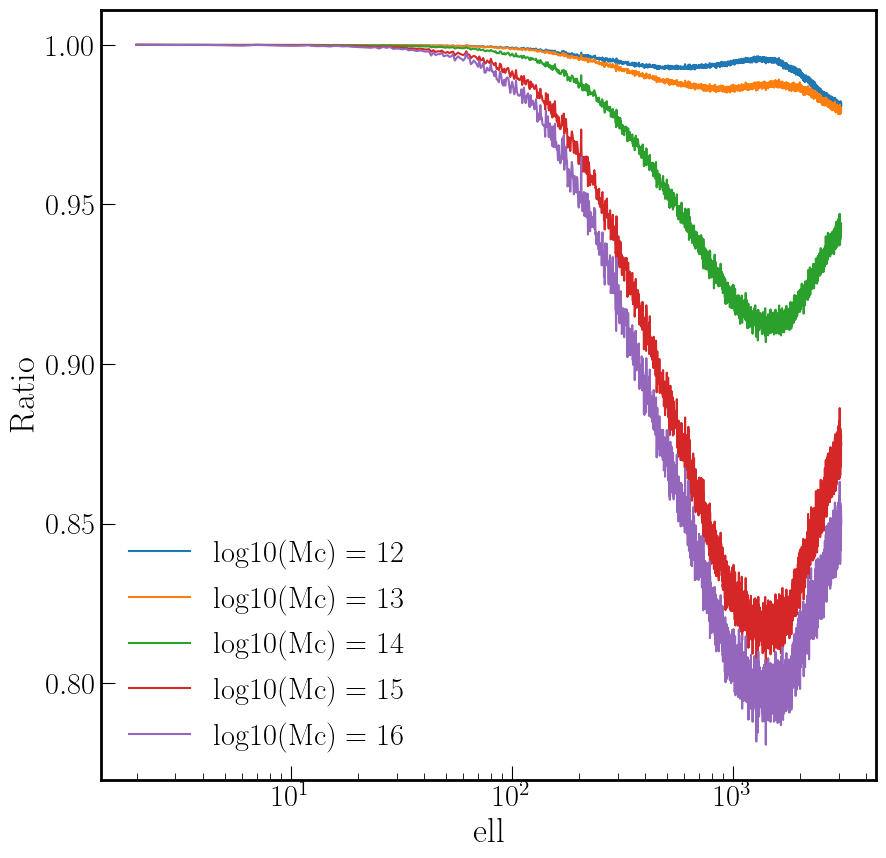

In [13]:
#Compute Cls of the original map
baseline = hp.anafast(counts)
ell      = np.arange(baseline.size)

for s, M in zip(baryonified_shells, M_c_vals):
    
    #Compute Cls of the modified map
    modified = hp.anafast(s)
    
    #Plot ratios. Dont show monopole and dipole modes
    plt.plot(ell[2:], (modified/baseline)[2:], label = f'log10(Mc) = {int(np.log10(M))}')
    

plt.legend(frameon = False)
plt.xlabel('ell', size = 25)
plt.ylabel('Ratio', size = 25)
plt.xscale('log')